# Labor 05: Többosztályos klasszifikáció - Egy vs Többi (One vs All)

### Kézzel írott számjegyek

Ebben a feladatban logisztikus regressziót fogunk alkalmazni, hogy elkülönítsünk kézzel írt számjegyeket (0 és 9 között). Ez a feladat manapság elterjedt a postai irányítószám leolvasásától kezdve a banki számlákon beírt számok felismeréséig és tovább.

### 1: importáljuk be a megfelelő csomagokat

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

### 2: Adatok beolvasása és vizualizálása

A Lab5data.mat fájl tartalmazza az adatainkat. A fájl 5000 darab 20x20 pixeles mintaképet tartalmaz. A mátrixban egy minta egy sornak felel meg, melyhez a képeket kiterítettük. A kiterítésre példa alább.

<img src="files/Pics/L05_Flatten.png" width=450>

Ennek megfelelően az adatokat beolvasva egy 5000x400-as bemeneti mátrixot fogunk kapni és egy 5000x1-es mátrixot, amik a címkéket tartalmazzák.

A megjelenítéshez pedig értelem szerűen ennek megfelelően kell a képeket vissza alakítanunk. A későbbiek során az algoritmusunknak minden pixel egy bemeneti változónak fog számítani, és minden pixel értéke egy 0-2 közé normalizált szürke árnyalatos érték. 

Shape of the dataset in order X and Y:
 (5000, 400) 
 (5000, 1) 

Now showing some random data from the dataset ...


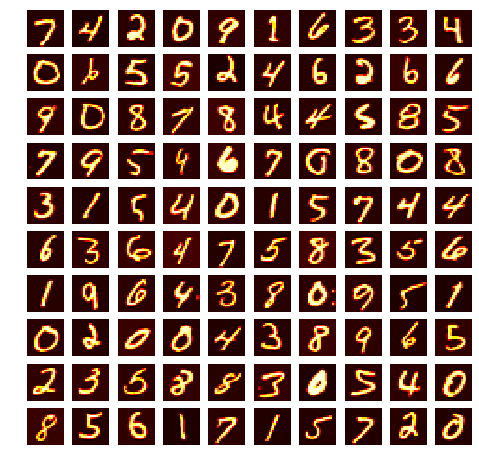

In [2]:
mat = loadmat("Lab5data.mat")                                       # .mat file beolvasása
X = mat["X"]                                                        # X rendezése
Y = mat["y"]                                                        # Y rebbdezése
m = X.shape[0]                                                      # adatok

print('''Shape of the dataset in order X and Y:
''',X.shape,'\n',Y.shape,'\n')

print("Now showing some random data from the dataset ...")          # kirajzoltatunk néhány random elemet
fig, axis = plt.subplots(10,10,figsize = (8,8))                     # mivel egy plotra akarunk több ábrát -> subplots
for i in range(10):                                                 # 10 x 10 kis ábrát akarunk
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,m+1),:].reshape(20,20,order="F"),cmap="hot")   # random beolvasás
        axis[i,j].axis("off")
plt.show()

### 3: Költségfüggvény és Gradient Descent

Emlékeztető: <br>
A korábbi gyakorlatok során bevezettük az alábbi költség függvényt, mely 2 osztály elkülönítésére volt alkalmas. $y=0\ és\ y=1$ eseteket különböztettünk csak meg.

$ C(w)=-\frac{1}{m}\sum_{i=1}^{m}y^i\cdot log(h_w(x^i))+(1-y^i)\cdot log(1-h_w(x^i))+\frac{\lambda}{2m}\sum_{j=1}^nw_j^2 $ 

A költség függvény deriváltját a gradiens módszerhez az alábbi képlettel számoltuk:

$ \frac{\partial}{\partial w_j}C(w)=\frac{1}{m}\sum_{i=1}^{m}(h_w(x^i)-y^i)\cdot x_j^i+\frac{\lambda}{m}w_j $ <br>
, ahol figyeljünk arra, hogy a BIAS tagot nem büntetjük!

Majd pedig a Gradient Descent súlymodosító alapképletével modosítottuk a súlyokat:

$w_j:=w_j-\mu\frac{\partial}{\partial w_j}C(w)$ 

Ezen három kulcs lépésből épül fel a Gradient Descent algoritmus.

Írja meg a költségfüggvényt és gradienseket kiszámoló lrCostFunction() függvényt.

In [3]:
def sigmoid(z):
    return 1/(1+np.exp(-z))                                                 # szigmoid függvény definíció

def lrCostFunction(w,X,Y,Lambda):                                           # logaritmusos költségfüggvény definíció
####################################################################
    m = len(Y)
    
    h = sigmoid(X@w) 
    w_reg = np.append(0, w[1:]).reshape(-1,1)
    
    p = Lambda/(2*m) * np.sum(w[1:]**2)
    C = (1/m) * np.sum((-Y * np.log(h)) - ((1-Y) * np.log(1-h))) + p 
    
    grad = 1/m * (X.transpose() @ (h-Y)) + (Lambda/m)*w_reg
####################################################################
    return C, grad

In [4]:
w_t = np.array([-2,-1,1,2]).reshape(4,1)                                 # teszt eset
X_t = np.array([np.linspace(0.1,1.5,15)]).reshape(3,5).T                  
X_t = np.hstack((np.ones((5,1)),X_t))                                    
Y_t = np.array([1,0,1,0,1]).reshape(5,1)  
Lambda = 3

C,grad = lrCostFunction(w_t, X_t, Y_t, Lambda)                           # költségfüggvény Lambda = 3
print('\nTest weight: [-2 -1 1 2]\n''''
Testing lrCostFunction() with regularization ... 
Cost function value: %.6f''' % C, ' (Expected: 2.534819)')
print('''\nExpected gradients:
 [[0.146561]
 [-0.548558]
 [0.724722]
 [1.398003]]
Computed gradients:\n''',grad)


Test weight: [-2 -1 1 2]

Testing lrCostFunction() with regularization ... 
Cost function value: 2.534819  (Expected: 2.534819)

Expected gradients:
 [[0.146561]
 [-0.548558]
 [0.724722]
 [1.398003]]
Computed gradients:
 [[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]


Írja meg a gradiens csükkentést végrehajtó gradientDescent() függvényt. Az egyes iterációkban mentse el egy változóba az aktuális költség értéket a lefutás nyomon követése érdekében.

In [5]:
def gradientDescent(X,Y,w,learning_rate,num_iters,Lambda):                          # gradiens módszer definíciója
############################################################    
    C_history = []

    for i in range(num_iters):
        C, grad =lrCostFunction(w,X,Y,Lambda)
        w = w - (learning_rate * grad)
        C_history.append(C)

    C_history = np.array(C_history)
############################################################    
    return w, C_history

### 4: One vs All

Célunk, hogy az eddig megismert és lekódolt 2 osztályos klasszifikáciüt kibővítsük több osztály szétválasztására is. Ezt megtehetjük egy egyszerű megfontolás mentén. Bármilyen klasszifikációs problémát vezessünk vissza két osztály elkülönítésére és hajtsuk végre ezt az eljárást annyiszor, ahány osztályt meg szeretnénk különböztetni.

<img src="files/Pics/L05_OneVSAll.png" width=450>

Így gyíkorlatilag a hipotézis függvényünk minden mintához hozzá rendel annyi valószínűséget, ahány osztályunk van. Ennek megfelően a döntésünk az lesz, amelyik osztály a legnagyobb valószínűséget fogja elérni.

$h_{w}^{(i)} = P(y=i|_{x,w})$ <br>
,ahol a fenti illusztráció szerint $i = 1,2,3$.

A számok osztáloyzása során 10 osztáylunk lesz, mivel a számjegyek 0-9 ig terjednek. Amire figyelni kell, hogy az adatbázisban a 0 számjegyek vannak 10-essel jelölve.

In [12]:
def oneVsAll(X, Y, num_labels, Lambda):                                     # One vs All definíciója
    m, n = X.shape[0],X.shape[1]                                            # 
    w_init = np.zeros((n + 1, 1))                                           # init súly oszlopvektor, n+1 x 1
    w_all = []  
    C_all = []

#############################################################               # A Bias tagokat ne felejtsük el hozzá adni
    X = np.hstack((np.ones((m, 1)), X))

    for i in range(1,num_labels + 1):
        w, C_history = gradientDescent(X, np.where(Y == i, 1, 0), w_init, 1, 50, Lambda)
        w_all.append(w)
        C_all.append(C_history)

    w_all = np.array(w_all).reshape(num_labels, -1)
    C_all = np.array(C_all)
#############################################################    
    return w_all, C_all

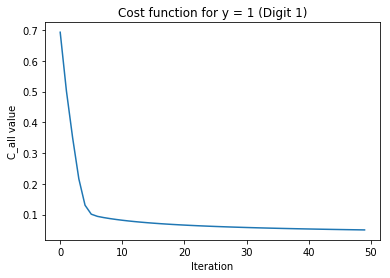

In [24]:
Lambda = 0.1
num_labels = 10

w_all, C_all = oneVsAll(X,Y,num_labels,Lambda)

plt.plot(C_all[0])
plt.title("Cost function for y = 1 (Digit 1)")
plt.xlabel("Iteration")
plt.ylabel("C_all value")
plt.show()

### 5: Predikció és pontosság

Nézzük vissza, hogy a tanított algoritmusunk milyen pontosságot érne el a tanító mintákon. A predikciós lépést most batch módszerrel az összes mintára egyszerre végezzük el. Minden mintára kiszámoljuk az összes osztályba való tartozás valószínűségét, majd a végleges predikciónkhoz kiválasztjuk ezek közül a legnagyobb valószínűséggel rendelkező osztályt. 

In [21]:
def predictionOneVsAll(w_all,X):
    m = X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
###########################################################
    predictions = X @ w_all.T                                # minta szám(m) x osztályok száma (num_label) méretű mátrix
    predictions = np.argmax(predictions,axis=1)+1            # alapból eggyel kevesebbet ad vissza
###########################################################    
    return predictions              

pred = predictionOneVsAll(w_all, X)
acc = sum(pred[:,np.newaxis]==Y)[0]/5000*100
print("Training Set Accuracy: %.2f" % acc,"%")

(5000, 10)
Training Set Accuracy: 88.46 %
